# Pix2pix
This part of the course includes more *science* part of the term "data science". In Part-I, we extracted around 600 patches of masses with corresponding masks. The masses were centred around the patch and we made sure that it was that way. The reason is that we want to minimise the amount of different things that our GAN model should learn. We are taking away all the extra noise from our training images.

Imagine that we want our GAN to be able to generate masses on whole mammograms (MG). Remember that the MGs have 4K resolution? Now our GAN has to learn:

1. How to generate a whole breast in two different views (CC and MLO)
2. How to generate a mass of a plausible shape and texture
3. Where to generate this mass in the breast that is anatomically plausible
   
Imagine you are dropped of in the middle of a rain forest and you need to find your way to the nearest village. Yet alone finding your way through the forest, you need to first of all survive your journey as there are wild animals, venomous snakes, and spiders! On top of that, you have to explore more areas in all directions that increases your chances to stumble upon a hungry jaguar.

This is what happens to a GAN model if we want it to generate whole MG scans. There is too much to explore for our model and many pitfals -- local minimas, mode collapse -- that it will encounter along the way. It is not impossible, but there is no way we are training a model with tens of millions of parameters using only 600 images. Or even with 1000, or even with tens of thousands.

On the other hand, if you are given a map of the forest and a compas, the only thing that you need to take care of is not to fall into a deep trench or get eaten by an anaconda. Still not an easy task, but now your chances are way higher to make it to the village!

In a similar way, we took out most of the how's and where's out of the equation in Part-I. Now, the model is given a patch with a mass always in the centre. The only things it has to learn is the shape and texture of the mass and the texture of the background within an enclosed square of 128x128 pixels.

More than that, we even guide the model to differentiate shapes and even explain what is a shape. How do we do that? Well, we saved the mass segmentation masks, didn't we! Now, we can give this mask as an input and tell GAN to fill in what is inside the white region with mass texture and what is outside with background texture. Just like this:

![pix2pixmass](images/pix2pix_mass.png)

It is indeed what pix2pix is doing!

![pix2pixcat](images/pix2pix_cat.png)

Check the demo of pix2pix [here](https://phillipi.github.io/pix2pix/)

We have the data cleaned up with a reduced search space. Now let's proceed with pix2pix!

**NOTE** You are not required to implement pix2pix, there are tested implementations online. Including the official github repository by the authors (although not in pytorch)  But if you are particularly interested in implementing it yourself, I encourage you to do so after the course. It is a good exercise and you can use all the code you implemented in this course to test your solution.

I provided the implementation of the model in `pix2pix.py` that we will use to train. In this part of the course you will learn how to load the data, how to implement and run a training and testing routine.

Let's get started!

### Imports and constants

In [1]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"]="1"
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchio as tio

# parts of pix2pix
from pix2pix import UnetGenerator, Discriminator

### Data loading
There are different ways of loading the data, but the task is clear: we need to constantly load the images, apply preprocessing and data augmentation, and feed it to our neural network. In Part-I, we gave you a class `BCDRDataset` that you used to load the whole MG and processed it to extract ROIs.

Here you will write your own version of `BCDRDataset` to load the image patches with corresponding segmentation masks that you extracted and saved in Part-I. You need to take into account how the images are structured. Here is the reminder:

<pre>
   |patches/
   |----|train/
   |----|----|1_scan.png
   |----|----|1_mask.png
   |----|----|*_scan.png
   |----|----|*_mask.png
   |----|----|N_scan.png
   |----|----|N_mask.png
   |----val/
   |----|----|*
   ***
</pre>

We need to do the following steps now:
1. Traverse through the image folders (e.g. "patches\train")
2. Create a `torchio` dataset. We have seen in Part-I how this library can be useful for medical images, and we are going to use some more functionalities that are useful for us.
3. Set up a `DataLoader` to loop through the training/validation images during training.

**TASK 1** Finish the function `get_sample_pairs(path)` that returns a list of tuples `[("path/to/1_mask.png", "path/to/1_scan.png"), (...), ...]`.

In [2]:
# A few more imports to define types
from typing import Callable, Optional, Tuple, List, Any, Dict

# Task 1, solution to step 1
def get_sample_pairs(path: str) -> List:
    """Returns a list of tuples of (mask, scan) pairs.
    Args:
        path (str): Path to the folder containing the images and masks.
    Returns:
        List: List of tuples of (mask, scan) pairs.
    """
    # TODO 1: Implement this function.
    # HINT: Use os.listdir() to get the list of files in the folder.
    # HINT: Use os.path.join() to get the path to a file in the folder.
    # HINT: image pairs are of the form <number>_mask.png and <number>_scan.png
    samples = []
    # <YOUR CODE HERE>
    return samples

Let's test the function for the validation set stored in "patches/val". We should see that the tuples in the list indeed contain paths to the images and the prefix number is the same for mask and scan pairs.


In [3]:
samples = get_sample_pairs("patches/val")
for sample in samples[:10]:
    print(sample)

('patches/val/1_mask.png', 'patches/val/1_scan.png')
('patches/val/25_mask.png', 'patches/val/25_scan.png')
('patches/val/6_mask.png', 'patches/val/6_scan.png')
('patches/val/9_mask.png', 'patches/val/9_scan.png')
('patches/val/2_mask.png', 'patches/val/2_scan.png')
('patches/val/27_mask.png', 'patches/val/27_scan.png')
('patches/val/5_mask.png', 'patches/val/5_scan.png')
('patches/val/11_mask.png', 'patches/val/11_scan.png')
('patches/val/17_mask.png', 'patches/val/17_scan.png')
('patches/val/22_mask.png', 'patches/val/22_scan.png')



We should see something like this:
```
[
    ('patches/val/48_mask.png', 'patches/val/48_scan.png'),
    ('patches/val/1_mask.png', 'patches/val/1_scan.png'),
    ('patches/val/25_mask.png', 'patches/val/25_scan.png'),
    ....
]
```

The following list is not correct (the prefix numbers don't match!):
```
[
    ('patches/val/8_mask.png', 'patches/val/4_scan.png'),
    ('patches/val/1_mask.png', 'patches/val/2_scan.png'),
    ('patches/val/2_mask.png', 'patches/val/5_scan.png'),
    ....
]
```

The following list is not correct (the prefix numbers match, but the order of mask and scan are not correct!):
```
[
    ('patches/val/48_scan.png', 'patches/val/48_mask.png'),
    ('patches/val/1_scan.png', 'patches/val/1_mask.png'),
    ('patches/val/25_scan.png', 'patches/val/25_mask.png'),
    ....
]
```

#### Torchio Data Structures

Torchio offers us the following data structures:
- Image: represents one medical image, for example MG
- Subject: represents a patient or a subject that can contain multiple images
- SubjectsDataset: a collection of subjects

Why do we need these structures, can't we just store them in arrays, lists, or dictionaries in python? That's a good question and the answer is yes, we can, but we'll need to take care of extra things along the way.

Let's take it step by step and compare each data structure of torchio to a pure python data structures (`list`, `dict`, etc.)

**Image** In python we would just store it in a `numpy` array or in `torch` tensor. One thing we need to make sure are the data types. So for every image, we always have to make sure the correct data type (`float32`, `uint8`, etc.). If we use `torchio` we just specify what type of image we are working with. See the comparison here:
```
# numpy
scan = np.array(...).astype(np.float32)
mask = np.array(...).astype(np.uint8)
# torchio
scan = tio.ScalarImage(...)
mask = tio.LabelMap(...)
```
Not much of a difference in this stage, but what if we perform some interpolation? In `numpy` we will need to make sure that the mask doesn't contain float values after the interpolation and cast it to `uint8` every time and take care of the numbers like 0.5, 0.8, etc. In `torchio`, when we run transformations, it will see that the image is a `LabelMap` or `ScalarImage` and take of the interpolation automatically.

**Subject** In python, we can store multiple images of the same patient in a `tuple` or `dict`:
```
# numpy
subject = {
    'mask': np.array(...).astype(np.uint8),
    'scan': np.array(...).astype(np.float32)
}
# torchio
subject = tio.Subject(
    mask = tio.LabelMap(...),
    scan = tio.ScalarImage(...)
)
```

Not much of a difference, right? If we don't do any data augmentation, then yes, not much of a difference. But we often do data augmentation. For example, let's say, we want to rotate the image by 90 degress at random.
```
# numpy
subject['mask'] = np.rot90(subject['mask'], k=1)  # k is the times the image is rotated
subject['scan'] = np.rot90(subject['scan'], k=1)
# torchio
transform = tio.RandomAffine(degrees=(0, 0, 90))  # we specify degrees for each dimension. Here we rotate randomly to 90 degress on the depth axis.
subject = transform(subject)
```
You can see the difference here! In `numpy` we need to apply the same augmentation to all the images of the subject and (not in this specific example) take care of the interpolations. In `torchio`, we only declare what transforms we want to apply, then send the whole subject as one and it applies the same transform to all the images and takes care of the interpolations. Note that `torchio` comes with a very good collection of data augmentation transforms (check [here](https://torchio.readthedocs.io/transforms/transforms.html))

**SubjectsDataset** This is the same as PyTorch's `Dataset` class, so we will not focus on this too much as both would work similarly. Similar to `torch.utils.data.Dataset`, `tio.SubjectsDataset` accepts `transforms` but the application of the `transforms` is already automatically called to the subjects within the `SubjectsDataset`. Don't worry if this part is not too clear, further we will do it in practice!

**TASK 2** Finish the implementation of the `get_subjects_list` that accepts a list of tuples with path pairs to image masks and scans (it's the `samples` list that we created earlier) and returns a list of `tio.Subjects`. Use the documentation of `torchio` for hints!

In [4]:
# Task 2
def get_subjects_list(samples: List[Tuple[str, str]]) -> List[tio.Subject]:
    """Returns a list of torchio.Subjects.
    Args:
        samples (List[Tuple[str, str]]): List of tuples of (mask, scan) pairs.
    Returns:
        List[tio.Subject]: List of torchio.Subjects.
    """
    subjects = []
    # TODO: Implement this function.
    # HINT: Use Image.open() to open an image. and .convert('L') to convert it to grayscale.
    # HINT: Use np.array() to convert the PIL image to a numpy array and cast it to float32.
    # NOTE: torchio image must be a 4D tensor of shape (NUM_CHANNELS, HEIGHT, WIDTH, DEPTH)
    # NOTE: Change the mask values to 0 and 1 (0 for background and 1 for foreground). By default PIL loads it as 0-255.
    # <YOUR CODE HERE>
    return subjects

Let's test your solution by simply calling the function with the `samples` list that we created earlier.

In [5]:
subjects = get_subjects_list(samples)
subject = subjects[0]
print(subject)
print(subject['mask'])
print(subject['scan'])
print(subject['mask']['data'].shape)
print(subject['scan']['data'].shape)

Subject(Keys: ('mask', 'scan'); images: 2)
LabelMap(shape: (1, 128, 128, 1); spacing: (1.00, 1.00, 1.00); orientation: RAS+; dtype: torch.FloatTensor; memory: 64.0 KiB)
ScalarImage(shape: (1, 128, 128, 1); spacing: (1.00, 1.00, 1.00); orientation: RAS+; dtype: torch.FloatTensor; memory: 64.0 KiB)
torch.Size([1, 128, 128, 1])
torch.Size([1, 128, 128, 1])


We printed bunch of stuff, but let's see if you have gotten the same output.

`print(subject)` gives us this:
```
Subject(Keys: ('mask', 'scan'); images: 2)
```
We can see that there are 2 images with keys `mask` and `scan`. Make sure the key names you got are the same.

Then, `print(subject['mask'])` and `print(subject['scan'])` should give you this:

```
LabelMap(shape: (1, 128, 128, 1); spacing: (1.00, 1.00, 1.00); orientation: RAS+; dtype: torch.FloatTensor; memory: 64.0 KiB)
ScalarImage(shape: (1, 128, 128, 1); spacing: (1.00, 1.00, 1.00); orientation: RAS+; dtype: torch.FloatTensor; memory: 64.0 KiB)
```
This tells you that both images are of type `LabelMap` and `ScalarImage` with shape `(1, 128, 128, 1)` and data type of `torch.FLoatTensor`. Make sure that the data type and the shapes are the same. Remember the last dimension in the shape is 1 because MG images are 2D, hence, the depth is only 1.

`print(subject['mask']['data'].shape)` and `print(subject['scan']['data'].shape)` should give as this:

```
torch.Size([1, 128, 128, 1])
torch.Size([1, 128, 128, 1])
```
In this `print`, we are accessing the torch tensors directly and printing it's shape.

If you get the same outputs, let's move to the next step where we create a `tio.SubjectsDataset` with transforms and plot some images with data augmentations!

In [6]:
# Let's define the transforms that does pre-processing and data augmentation
transforms = tio.Compose([
    tio.RescaleIntensity(out_min_max=(0, 1)),
    # tio.OneOf({
    #     tio.RandomFlip(axes=(0, 1)): 0.5,  # flip vertically and horizontally
    #     tio.RandomAffine(scales=(0.8, 1.2, 0.8, 1.2, 1, 1)): 0.5,  # scale width and height, keep the depth same (which is 1 anyway)
    #     tio.RandomAffine(degrees=(0, 0, 0, 0, -90, 90)): 0.5,  # rotate between 0 and 90 degrees along the depth axis
    #     tio.RandomBlur(std=0.2): 0.5,  # blur the image, very little blur, we don't want to change the intensities too much
    #     tio.RandomNoise(std=0.05): 0.5  # add noise to the image, the same as in blur, we don't want to change the intensities too much
    # })
])

# What we did here is to declare a transform, that includes two components:
# 1. RescaleIntensity: This will rescale the intensity of the image to be between 0 and 1 for all the images
# 2. OneOf: This will randomly apply one of the transforms inside it. The probability of each transform is given as a dictionary.
# We set equal probability for all the augmentation transforms

# Let's create the dataset now with this transforms
dataset = tio.SubjectsDataset(subjects, transform=transforms)

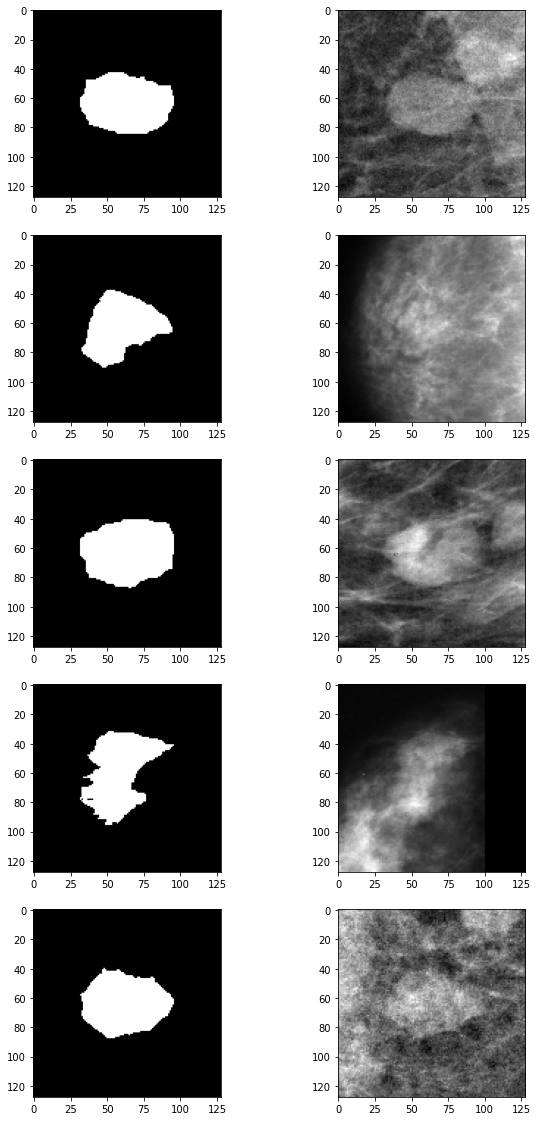

In [7]:
# Let's plot 5 samples from the dataset and see how the data augmentation works
fig, axes = plt.subplots(5, 2, figsize=(10, 20))
for i in range(5):
    sample = dataset[i]
    axes[i, 0].imshow(sample['mask']['data'][0, ..., 0], cmap='gray')
    axes[i, 1].imshow(sample['scan']['data'][0, ..., 0], cmap='gray')
plt.show()
# NOTE Run this cell multiple times to see different augmentations


In [8]:
# Let's check the intensity range of the images
print("Min intensity of the mask: ", dataset[0]['mask']['data'].min())
print("Max intensity of the mask: ", dataset[0]['mask']['data'].max())
print("Min intensity of the scan: ", dataset[0]['scan']['data'].min())
print("Max intensity of the scan: ", dataset[0]['scan']['data'].max())

Min intensity of the mask:  tensor(0.)
Max intensity of the mask:  tensor(1.)
Min intensity of the scan:  tensor(0.)
Max intensity of the scan:  tensor(1.)


### Combatting data scarcity
So far so good, but we didn't address the issue that we mentioned in the beginning of this part. We only have around 500 training images. And we want the network to learn to map segmentation masks into realistic MG masses like this:

![pix2pixmass](images/pix2pix_mass.png)

It is true that we greatly minimised the things that the GAN should learn. Coming back to the forest analogy, we gave a map and a compas to find the direction. But we didn't give any tool to protect itself from predators along the way. Now, let's tackle this issue.

We will adopt the idea from this recent paper titled "Controllable skin lesion synthesis using texture patches, Bezier curves and conditional GANs" (link [here](https://www.researchgate.net/profile/Dario-Oliveira-3/publication/341588238_Controllable_Skin_Lesion_Synthesis_Using_Texture_Patches_Bezier_Curves_and_Conditional_GANs/links/5f1837e2a6fdcc9626a6a03d/Controllable-Skin-Lesion-Synthesis-Using-Texture-Patches-Bezier-Curves-and-Conditional-GANs.pdf)).

One of the ideas of the ideas we want to implement is shown here:

![oliveira_etal](images/oliveira_tile.png)

As you can see, the they select two small patches from inside the lesion and outside the lesion. Then, they use the mask to tile up these small patches into the whole image. The nice part of this idea is that we can extract the small patches from random part of the image each time we use it for training. This tiled image will be used as the input to our GAN training. Let's follow their technique that will help us to obtain an infinite amount of training samples out of 500!

Can you see another benefit of doing this? Now, along with the shape information, we also give an idea of how texture inside the lesion and outside should look like, to a certain degree of course. In summary, we have given our model a map, a compas, and now a knife! Let's hope it can make it out of the rain forest!

**TASK 3** In this task you have to complete the function that accepts a `tio.Subject` that we defined before, and returns a new subject that replaces the mask with the tiled image. You have some hints to help you.

In [9]:
# Task 3. Function that accepts a tio.Subject and fills the mask with small patches extracted from the scan image
# and returns a new tio.Subject that replacing the mask with the tiled image. The tiled image should be constructed like this:
# 1. Take a random patch of size 32 x 32 from the scan image inside the mask region
# 2. Fill the mask region with this patch
# 3. Take another random patch of size 32 x 32 from the scan image outside the mask region
# 4. Fill the background region with this patch (i.e. the region where the mask is 0)
def tile_mask(subject: tio.Subject) -> tio.Subject:
    """Returns a new tio.Subject with tiled mask.
    Args:
        subject (tio.Subject): Input tio.Subject.
    Returns:
        tio.Subject: Output tio.Subject.
    """
    mask = subject['mask']['data'][0, ..., 0]
    scan = subject['scan']['data'][0, ..., 0]
    # mask and scan are torch tensors
    fg_tiled = torch.zeros_like(mask)
    bg_tiled = torch.zeros_like(mask)
    # get a random patch of size 32 x 32 from the scan image inside the mask region
    patch_size = 32
    patch_size_half = patch_size // 2
    # erode the mask by half the patch size
    # we can do this by convolving the mask with a 2D kernel of size 32 x 32 with all 1s
    eroded_mask = torch.nn.functional.conv2d(mask[None, None, ...], torch.ones((1, 1, patch_size, patch_size))).squeeze()
    # normalize eroded mask
    eroded_mask = (eroded_mask - eroded_mask.min()) / (eroded_mask.max() - eroded_mask.min())
    eroded_mask[eroded_mask < 0.9] = 0
    # let's pad it to the original size
    pad = (mask.shape[0] - eroded_mask.shape[0]) // 2
    eroded_mask = torch.nn.functional.pad(eroded_mask, (pad, pad+1, pad, pad+1)).bool()

    # Solution
    fg_indices = torch.nonzero(eroded_mask)
    # drop indices that are too close to the boundary
    fg_indices = fg_indices[(fg_indices[:, 0] > patch_size_half) & (fg_indices[:, 0] < mask.shape[0] - patch_size_half) & (fg_indices[:, 1] > patch_size_half) & (fg_indices[:, 1] < mask.shape[1] - patch_size_half)]
    # get a random index from the indices where the mask is 1
    fg_index = fg_indices[torch.randint(len(fg_indices), size=(1,))][0]
    # get a random patch of size 32 x 32 from the scan image at this index (be careful of the boundaries)
    fg_patch = scan[fg_index[0] - patch_size_half:fg_index[0] + patch_size_half, fg_index[1] - patch_size_half:fg_index[1] + patch_size_half]
    # fill the fg_tiled image with this patch
    fg_tiled = torch.tile(fg_patch, (mask.shape[0] // patch_size, mask.shape[1] // patch_size))
    # get a random patch of size 32 x 32 from the scan image outside the mask region

    # <YOUR CODE HERE>
    # Hint: Follow similar steps as above. Careful with the copy-paste though, you need to select the indices where the mask is 0
    # get the final tiled image by combining the fg_tiled and bg_tiled images based on the mask


    tiled = fg_tiled * mask + bg_tiled * (1 - mask)
    tiled = tiled.unsqueeze(0).unsqueeze(-1)
    tiled = tiled.to(torch.float32)
    # create a new tio.Subject with the tiled image
    tiled_subject = tio.Subject(
        mask=tio.ScalarImage(tensor=tiled),
        scan=subject['scan']
    )
    return tiled_subject


Let's test it!

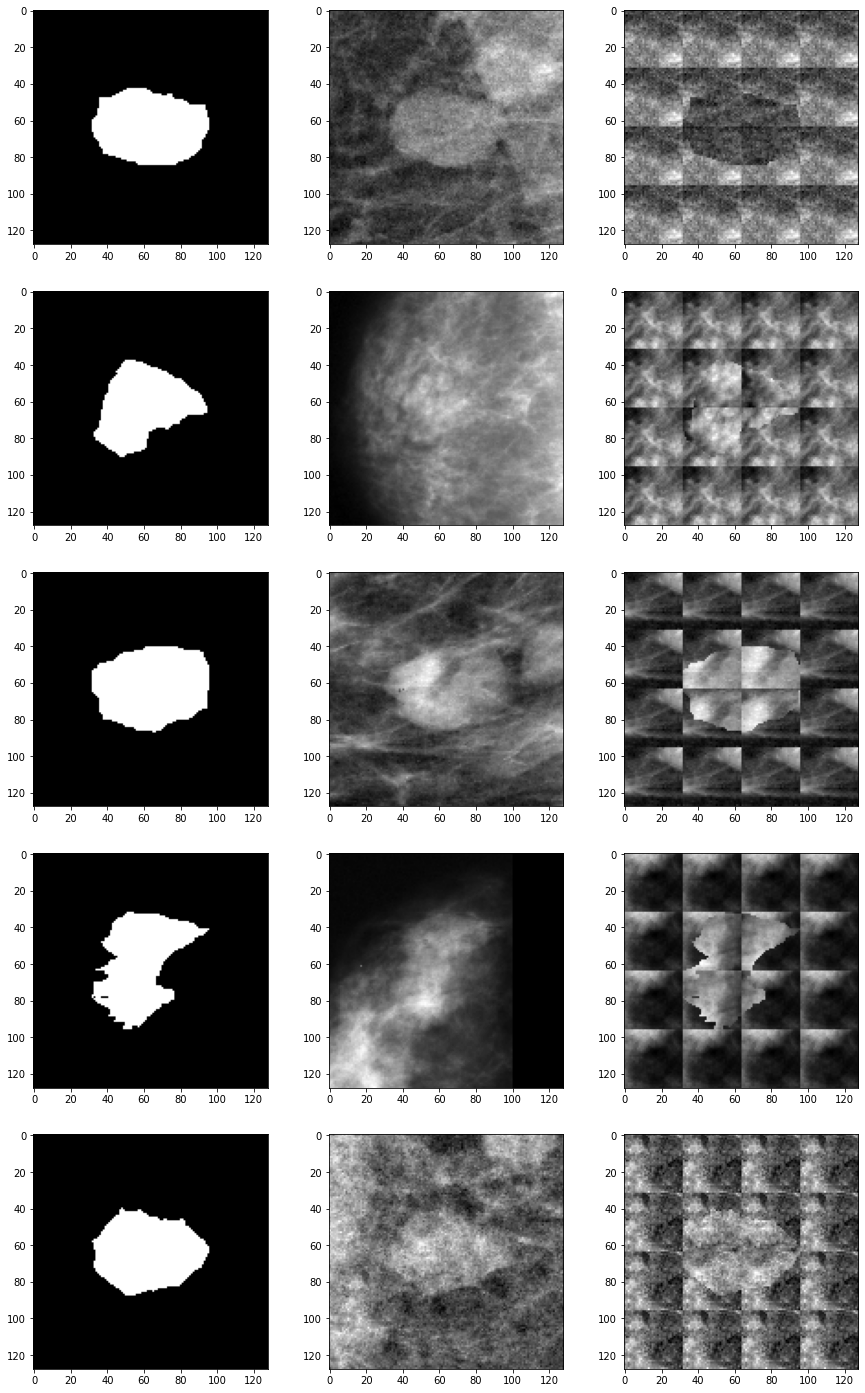

In [10]:
# test the function for 5 samples
fig, axes = plt.subplots(5, 3, figsize=(15, 25))
for i in range(5):
    sample = dataset[i]
    tiled_sample = tile_mask(sample)
    axes[i, 0].imshow(sample['mask']['data'][0, ..., 0], cmap='gray')
    axes[i, 1].imshow(sample['scan']['data'][0, ..., 0], cmap='gray')
    axes[i, 2].imshow(tiled_sample['mask']['data'][0, ..., 0], cmap='gray')
plt.show()

If everything went well, you should see something like this:
![tiled_image](images/tiled_mass1.png)

#### Custom `Dataset`
Now we have the function that can generate such tiled images as in the Oliveira et al paper! We want to generate these random tiled inputs to GAN during training. To do this, let's create a custom PyTorch `Dataset` that converts the subject's mask inside the `tio.SubjectsDataset` into a new subject with tiled textures. Think of it as another layer to our dataset. The first layer being the `tio.SubjectsDataset` that does the traditional data augmentation, and the second layer that creates tiled images.

**NOTE** This maybe not the best way to do this, in fact, generating images on the fly will be slow! But we are not aiming for efficiency right now. Once again, I encourage you to think of different implementations that could speed up the process. Perhaps, these two layers of data augmentation combined into one would be the first easy step.

In [11]:
# Task 4. Create a new dataset that applies the tile_mask function on the dataset
class TiledDatased(Dataset):
    def __init__(self, dataset: tio.SubjectsDataset):
        self.dataset = dataset

    def __len__(self) -> int:
        return len(self.dataset)

    def __getitem__(self, idx: int) -> tio.Subject:
        sample = self.dataset[idx]
        tiled_sample = tile_mask(sample)
        return tiled_sample

# That was simple, wasn't it? Think of the ways we can improve the efficiency and reduce the amount of code!

#### Putting things together (finalise the data loaders)
If you see that min-max intensities for both mask and the scan are 0 and 1, then we should define our loaders for train and validation sets that we will use in training. We will define a data loader for the test set later because we will not use it during training.

In [12]:
# Data loaders for train and validation sets
# 1. get the pairs of (mask, scan) images
train_samples = get_sample_pairs("patches/train")
val_samples = get_sample_pairs("patches/val")
# 2. create the subjects list
train_subjects = get_subjects_list(train_samples)
val_subjects = get_subjects_list(val_samples)
# 3. create the datasets (with transforms that we defined above)
train_dataset = tio.SubjectsDataset(train_subjects, transform=transforms)
# NOTE: We don't want to apply data augmentation on the validation set
val_dataset = tio.SubjectsDataset(val_subjects)
# 4. create the TiledDataset
train_dataset = TiledDatased(train_dataset)
val_dataset = TiledDatased(val_dataset)
# 5. create the data loaders
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

Batch shape torch.Size([32, 1, 128, 128, 1])
Min intensity of the mask:  tensor(0.)
Max intensity of the mask:  tensor(1.)
Min intensity of the scan:  tensor(0.)
Max intensity of the scan:  tensor(1.)


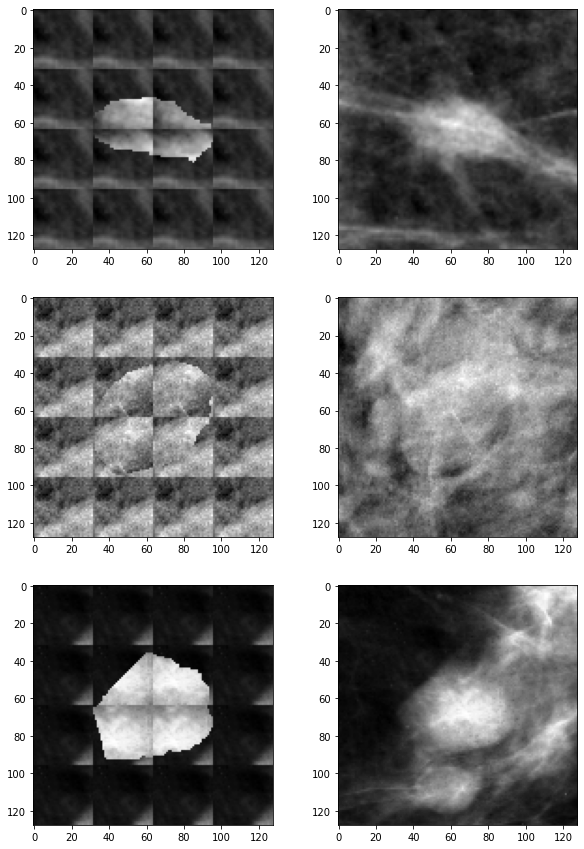

In [13]:
# test the train loader
batch = next(iter(train_loader))
print('Batch shape', batch['mask']['data'].shape)

# Let's check the intensity range of the images once again
print("Min intensity of the mask: ", dataset[0]['mask']['data'].min())
print("Max intensity of the mask: ", dataset[0]['mask']['data'].max())
print("Min intensity of the scan: ", dataset[0]['scan']['data'].min())
print("Max intensity of the scan: ", dataset[0]['scan']['data'].max())

# plot 3 samples from the batch
fig, axes = plt.subplots(3, 2, figsize=(10, 15))
for i in range(3):
    axes[i, 0].imshow(batch['mask']['data'][i, 0, ..., 0], cmap='gray')
    axes[i, 1].imshow(batch['scan']['data'][i, 0, ..., 0], cmap='gray')
plt.show()

### Pix2Pix training
Now we have the data set up with preprocessing and augmentations. Let's go ahead with the training routine.

As usual, you will need to complete some tasks along the way!

In [14]:
# Let's define the constants
LR = 2e-4  # learning rate (set the same as in the paper of pix2pix)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# DEVICE = torch.device("cpu")  # NOTE: uncomment this if GPU is giving you problems
print(f"Using device: {DEVICE}")

Using device: cuda


In [15]:
# Let's define the model
generator = UnetGenerator(input_nc=1, output_nc=1).to(DEVICE)
# here, the input and output channels are 1 because we are dealing
# with grayscale images
discriminator = Discriminator(input_nc=2).to(DEVICE)
# here, the input channels are 2 because we will concatenate the
# output of the generator and the scan that corresponds to the input mask

# optimizers (the betas are set the same way as in the paper)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=LR, betas=(0.5, 0.999))
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=LR, betas=(0.5, 0.999))

In [16]:
inp = torch.randn(1, 1, 128, 128).to(DEVICE)
out = generator(inp)
print("Generator output shape: ", out.shape)
out = discriminator(torch.cat([inp, out], dim=1))
print("Discriminator output shape: ", out.shape)

Generator output shape:  torch.Size([1, 1, 128, 128])
Discriminator output shape:  torch.Size([1, 1, 14, 14])


#### Loss functions
We need to define the losses to train our GAN model.

According to the pix2pix paper (link [here](https://arxiv.org/pdf/1611.07004.pdf)), they train to maximize `log D(x, G(x))`. In addition, they divide the objective by 2 while optimizing `D`, which slows down the rate at which `D` learns relative to `G`. Here, `D` and `G` are our discriminator and generator, respectively. `x` is the `mask` and `G(x)` is the generated synthetic image. Here is the schematic of the training process:

![pix2pix_train](images/pix2pix_train.png)

The discriminator, observes both the `mask` and the `scan` and learns to distinguish real and fake pairings. They authors of pix2pix, define the final loss function as this:

![pix2pix_loss](images/pix2pix_loss.png)

It consists of two terms:
1. The conditional GAN loss (or adversarial loss)
2. L1 loss weighted by lambda

Then, our optimizers need to find optimal parameters for discriminator (D) and generator (G) by maximizing the score of D and at the same time minimzing the score of G.

Let's implement this! We define two functions that take care of loss computation for generator and discriminator separately, because in GAN training we train them in an alternating manner. And the discriminator loss does not include the L1 loss. Some little things for convenience.

In [17]:
# The adversarial loss is the same as the binary cross entropy loss
adversarial_loss = nn.BCELoss()
# Let's define the L1 loss
l1_loss = nn.L1Loss()
# This is the lambda value that gave the best results in the paper
LAMBDA = 100  

# TASK 3
def generator_loss(generated_image: torch.Tensor, 
                   real_image: torch.Tensor,
                   discrimantor_output: torch.Tensor,
                   real_target: torch.Tensor) -> torch.Tensor:
    """Calculates the generator loss.
    Args:
        generated_image (torch.Tensor): The generated image.
        real_image (torch.Tensor): The real image.
        discrimantor_output (torch.Tensor): 1 if discriminator thinks the image is real, 0 if fake.
        target_label (torch.Tensor): 1 if the image is real, 0 if it is fake.
    Returns:
        torch.Tensor: The generator loss.
    """
    # TODO complete the function
    # HINT: remember the total loss is the sum of the adversarial loss and the L1 loss
    # HINT: don't forget the weight lambda to the L1 loss
    # <YOUR CODE HERE>
    total_loss = 0
    return total_loss

def discriminator_loss(discriminator_output: torch.Tensor, 
                       target_label: torch.Tensor) -> torch.Tensor:
    """Calculates the discriminator loss.
    Args:
        discriminator_output (torch.Tensor): 1 if discriminator thinks the image is real, 0 if fake.
        target_label (torch.Tensor): 1 if the image is real, 0 if it is fake.
    Returns:
        torch.Tensor: The discriminator loss.
    """
    total_loss = adversarial_loss(discriminator_output, target_label)
    return total_loss

Let's define a training loop that iterates `EPOCHS` times and trains the generator and discriminator one after the other with minibatches of size `BATCH_SIZE`.

In [37]:
# lists to keep track of the losses over time
d_loss_history, g_loss_history = [], []
# directory to save the model checkpoints
checkpoint_dir = "checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

EPOCHS = 200  # number of epochs
discriminator_output_size = 14

print(f"Using device: {DEVICE}")

generator.train()
discriminator.train()

for epoch in range(EPOCHS):
    d_iteration_losses, g_iteration_losses = [], []
    for batch in train_loader:
        # remember the mask and scan have shapes (batch_size, 1, 128, 128, 1)
        # but our generator expects (batch_size, 1, 128, 128)
        # so we need to squeeze the last dimension
        mask = batch['mask']['data'].squeeze(-1).to(DEVICE)
        scan = batch['scan']['data'].squeeze(-1).to(DEVICE)

        # get the number of samples in the batch (the last batch might be smaller)
        num_samples = mask.shape[0]

        # -----DISCRIMINATOR TRAINING-----
        # reset the gradients of discriminator
        d_optimizer.zero_grad()

        # genearate a synthetic scan from the mask
        generated_scan = generator(mask)

        # concatenate the generated scan and the mask
        fake_input_for_discriminator = torch.cat((mask, generated_scan), dim=1)
        # get the discriminator output for the fake input
        # NOTE we don't want to update the generator parameters when we are updating the discriminator
        # that's why we use the detach() method
        fake_discriminator_output = discriminator(fake_input_for_discriminator.detach())
        # create a target_label for the fake input
        fake_target_label = torch.zeros(num_samples, 1, discriminator_output_size, discriminator_output_size).to(DEVICE)
        # calculate the discriminator loss for the fake input
        fake_discriminator_loss = discriminator_loss(fake_discriminator_output, fake_target_label)

        # concatenate the real scan and the mask
        real_input_for_discriminator = torch.cat((mask, scan), dim=1)
        # get the discriminator output for the real input
        real_discriminator_output = discriminator(real_input_for_discriminator)
        # create a target_label for the real input (30 comes from the PatchGAN architecture)
        real_target_label = torch.ones(num_samples, 1, discriminator_output_size, discriminator_output_size).to(DEVICE)
        # calculate the discriminator loss for the real input
        real_discriminator_loss = discriminator_loss(real_discriminator_output, real_target_label)

        # calculate the total discriminator loss
        total_discriminator_loss = (fake_discriminator_loss + real_discriminator_loss) / 2
        # update the discriminator parameters
        total_discriminator_loss.backward()
        d_optimizer.step()
        # add the loss to the history
        d_iteration_losses.append(total_discriminator_loss.item())

        # -----GENERATOR TRAINING-----
        # reset the gradients of generator
        g_optimizer.zero_grad()
        fake_scan_pair = torch.cat((mask, generated_scan), dim=1)
        # get the discriminator output for the fake input
        fake_discriminator_output = discriminator(fake_scan_pair)
        total_generator_loss = generator_loss(generated_scan, scan, fake_discriminator_output, real_target_label)
        # update the generator parameters
        total_generator_loss.backward()
        g_optimizer.step()
        # add the loss to the history
        g_iteration_losses.append(total_generator_loss.item())
    # calculate the mean loss for the epoch
    d_loss_history.append(torch.mean(torch.FloatTensor(d_iteration_losses)))
    g_loss_history.append(torch.mean(torch.FloatTensor(g_iteration_losses)))
    print(f"Epoch {epoch + 1}/{EPOCHS}, d_loss: {d_loss_history[-1]:.4f}, g_loss: {g_loss_history[-1]:.4f}")
    # save the generator and discriminator models every 50 epochs
    if (epoch + 1) % 50 == 0:
        torch.save(generator.state_dict(), f"{checkpoint_dir}/generator_{epoch + 1}.pth")
        torch.save(discriminator.state_dict(), f"{checkpoint_dir}/discriminator_{epoch + 1}.pth")

Using device: cuda
Epoch 1/200, d_loss: 0.1635, g_loss: 10.0361
Epoch 2/200, d_loss: 0.1697, g_loss: 10.5646
Epoch 3/200, d_loss: 0.3283, g_loss: 9.6047
Epoch 4/200, d_loss: 0.2292, g_loss: 10.4296
Epoch 5/200, d_loss: 0.2064, g_loss: 10.1479
Epoch 6/200, d_loss: 0.1723, g_loss: 9.9925
Epoch 7/200, d_loss: 0.2613, g_loss: 9.6894
Epoch 8/200, d_loss: 0.3078, g_loss: 10.3245
Epoch 9/200, d_loss: 0.2960, g_loss: 10.3545
Epoch 10/200, d_loss: 0.1994, g_loss: 9.8579
Epoch 11/200, d_loss: 0.2003, g_loss: 9.6244
Epoch 12/200, d_loss: 0.2473, g_loss: 9.7228
Epoch 13/200, d_loss: 0.4041, g_loss: 10.7662
Epoch 14/200, d_loss: 0.2951, g_loss: 9.7974
Epoch 15/200, d_loss: 0.2623, g_loss: 9.6564
Epoch 16/200, d_loss: 0.2225, g_loss: 9.5201
Epoch 17/200, d_loss: 0.2316, g_loss: 10.2677
Epoch 18/200, d_loss: 0.3202, g_loss: 9.7937
Epoch 19/200, d_loss: 0.3697, g_loss: 9.1488
Epoch 20/200, d_loss: 0.2394, g_loss: 9.6087
Epoch 21/200, d_loss: 0.2819, g_loss: 9.4506
Epoch 22/200, d_loss: 0.2851, g_loss:

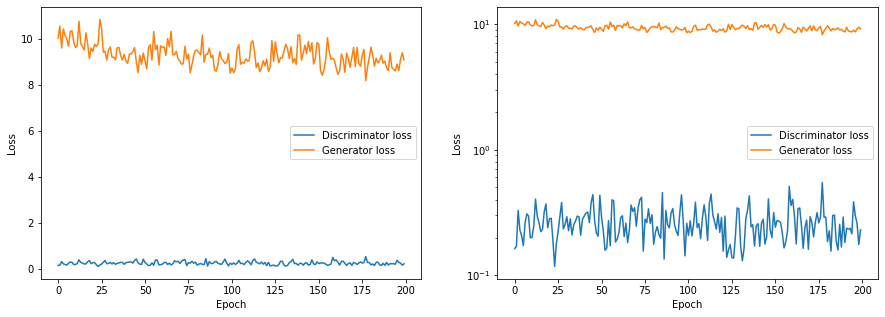

In [38]:
# plot the losses history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(d_loss_history, label="Discriminator loss")
ax1.plot(g_loss_history, label="Generator loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()
ax2.plot(d_loss_history, label="Discriminator loss")
ax2.plot(g_loss_history, label="Generator loss")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")
ax2.set_yscale("log")
ax2.legend()
plt.show()


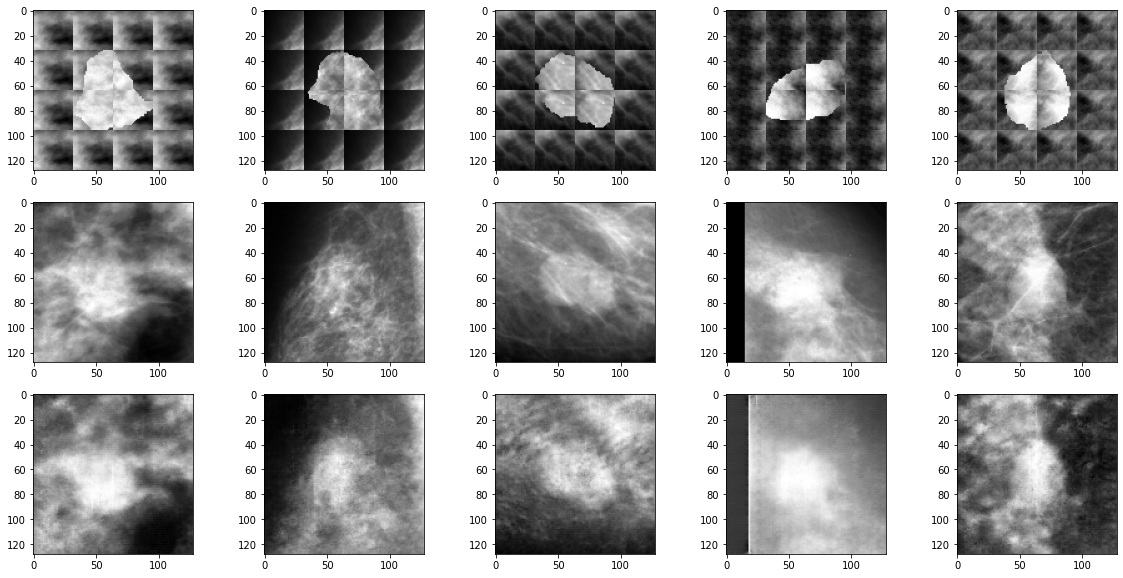

In [39]:
val_sample = next(iter(train_loader))
mask = val_sample['mask']['data'].squeeze(-1).to(DEVICE)
scan = val_sample['scan']['data'].squeeze(-1).to(DEVICE)
generator.eval()
with torch.no_grad():
    generated_scan = generator(mask)
    # plot first 5 samples in order first mask, then scan, then generated scan
    fig, axes = plt.subplots(3, 5, figsize=(20, 10))
    for i in range(5):
        axes[0, i].imshow(mask[i].cpu().numpy().squeeze(), cmap='gray')
        axes[1, i].imshow(scan[i].cpu().numpy().squeeze(), cmap='gray')
        axes[2, i].imshow(generated_scan[i].cpu().detach().numpy().squeeze(), cmap='gray')
    plt.show()

### End of Part-II
Let's hope we could finish the training by this time. If not, nothing to worry about. I'll share with you a model that has been trained for a long time and we can move on to the next part where we will use this model to generate synthetic images with random shapes using Bezier curves!